# 环境

In [1]:
!uv add silero-vad
!uv add tqdm
!uv add numpy
!uv add matplotlib
!uv add torch

Resolved 145 packages in 0.70ms
Audited 116 packages in 0.03ms
Resolved 145 packages in 0.56ms
Audited 116 packages in 0.04ms
Resolved 145 packages in 0.57ms
Audited 116 packages in 0.04ms
Resolved 145 packages in 0.77ms
Audited 116 packages in 0.04ms
Resolved 145 packages in 0.73ms
Audited 116 packages in 0.03ms


In [2]:
import os
import time

from silero_vad import load_silero_vad, read_audio, get_speech_timestamps, VADIterator, save_audio
import numpy as np
import tqdm
import matplotlib.pylab as plt
import torch

def calculate_db(chunk):
    rms = np.sqrt(np.mean(np.square(chunk)))
    return 20 * np.log10(rms + 1e-7) if rms > 0 else -np.inf

model = load_silero_vad(onnx=True)
prob_model = load_silero_vad(onnx=True)
SAMPLING_RATE = 16000
window_size_samples = 512 if SAMPLING_RATE == 16000 else 256

WAV_DIR_PATH = 'exp_data/2025-07-29_16-02-50-367/equidistant_audio_records'
WAV_FILES = filter(lambda x: not x.startswith('.'), os.listdir(WAV_DIR_PATH))
WAV_PATHS = [os.path.join(WAV_DIR_PATH, e) for e in sorted(WAV_FILES)]
WAV_PATHS

['exp_data/2025-07-29_16-02-50-367/equidistant_audio_records/2025-07-29_16-02-50-489_5s_80000samples.wav',
 'exp_data/2025-07-29_16-02-50-367/equidistant_audio_records/2025-07-29_16-02-55-489_5s_80000samples.wav',
 'exp_data/2025-07-29_16-02-50-367/equidistant_audio_records/2025-07-29_16-03-00-489_5s_80000samples.wav',
 'exp_data/2025-07-29_16-02-50-367/equidistant_audio_records/2025-07-29_16-03-05-489_5s_80000samples.wav']

# 流式VAD样例

In [3]:
# Provided by Alexander Veysov (https://github.com/snakers4/silero-vad/blob/master/examples/pyaudio-streaming/pyaudio-streaming-examples.ipynb)
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

vad_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
vad_sec_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
speech_probs = []
wavs = []
for path in WAV_PATHS:
    wav = read_audio(path, sampling_rate=SAMPLING_RATE)
    # speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
    # print(speech_timestamps)
    # print(wav.dtype, wav.shape)
    wavs.append(wav)
wav = torch.concat(wavs)

dbs = []
cnt = 0
# for i in tqdm.trange(0, len(wav), window_size_samples):
temp_ts = time.time()
time_gaps = []
for i in range(0, len(wav), window_size_samples):
    time_gaps.append(time.time()-temp_ts)
    temp_ts = time.time()
    chunk = wav[i: i+ window_size_samples]


    int_chunk = chunk.numpy() * 32767
    chunk_bytes = int_chunk.astype(np.int16).tobytes()
    db = calculate_db(int_chunk)
    dbs.append(db)

    if len(chunk) < window_size_samples:
        break
    speech_dict = vad_iterator(chunk)
    if speech_dict:
        print(speech_dict, sep=' ', end='')
        cnt += 1
        if cnt > 0 and cnt % 4 == 0:
            print()
            # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
    speech_dict = vad_sec_iterator(chunk, return_seconds=True)
    if speech_dict:
        print(speech_dict, sep=' ', end='')
        cnt += 1
        if cnt > 0 and cnt % 4 == 0:
            print()
            # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
        
    speech_prob = prob_model(chunk, SAMPLING_RATE).item()
    speech_probs.append(speech_prob)


/Users/rjx/Documents/GitHub/windowed-silero-vad/.venv/lib/python3.10/site-packages/silero_vad/utils_vad.py:135: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  list_backends = torchaudio.list_audio_backends()
/Users/rjx/Documents/GitHub/windowed-silero-vad/.venv/lib/python3.10/site-packages/silero_vad/utils_vad.py:146: UserWarning: torchaudio.sox_effects.sox_effects.apply_effects_file has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 releas

{'start': 16928}{'start': 1.1}{'end': 1.5}{'end': 24032}
{'start': 127520}{'start': 8.1}{'end': 8.2}{'end': 131040}


## 人声概率在时间上分布

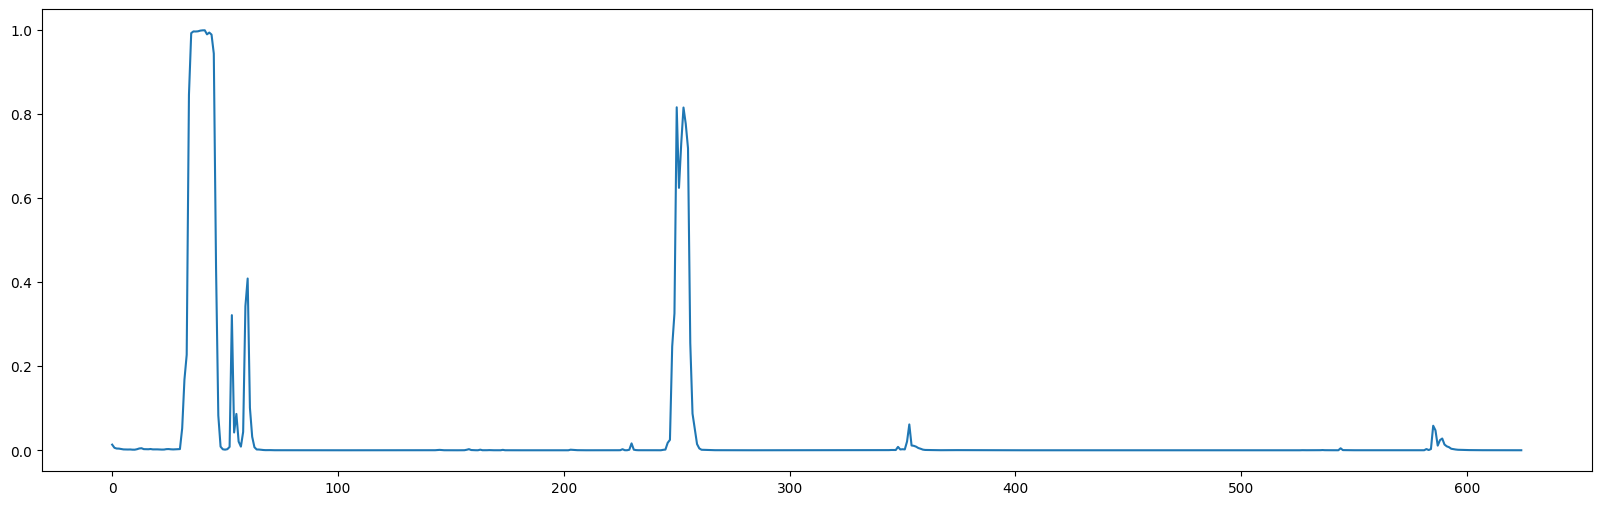

概率列表长度：625
[0.013444989919662476, 0.005956083536148071, 0.004146605730056763, 0.003982186317443848, 0.0030310750007629395, 0.0020672380924224854, 0.0019020438194274902, 0.001814424991607666, 0.00194549560546875, 0.001450181007385254]
[8.96155834197998e-05, 8.594989776611328e-05, 8.323788642883301e-05, 9.119510650634766e-05, 8.463859558105469e-05, 8.26120376586914e-05, 7.539987564086914e-05, 7.608532905578613e-05, 7.599592208862305e-05, 7.703900337219238e-05]


In [4]:
plt.figure(figsize=(20,6))
plt.plot(speech_probs)
plt.show()
print(f'概率列表长度：{len(speech_probs)}')

print(speech_probs[:10])
print(speech_probs[-10:])

## 分贝数
看来啸叫噪音不比其他噪音分贝低

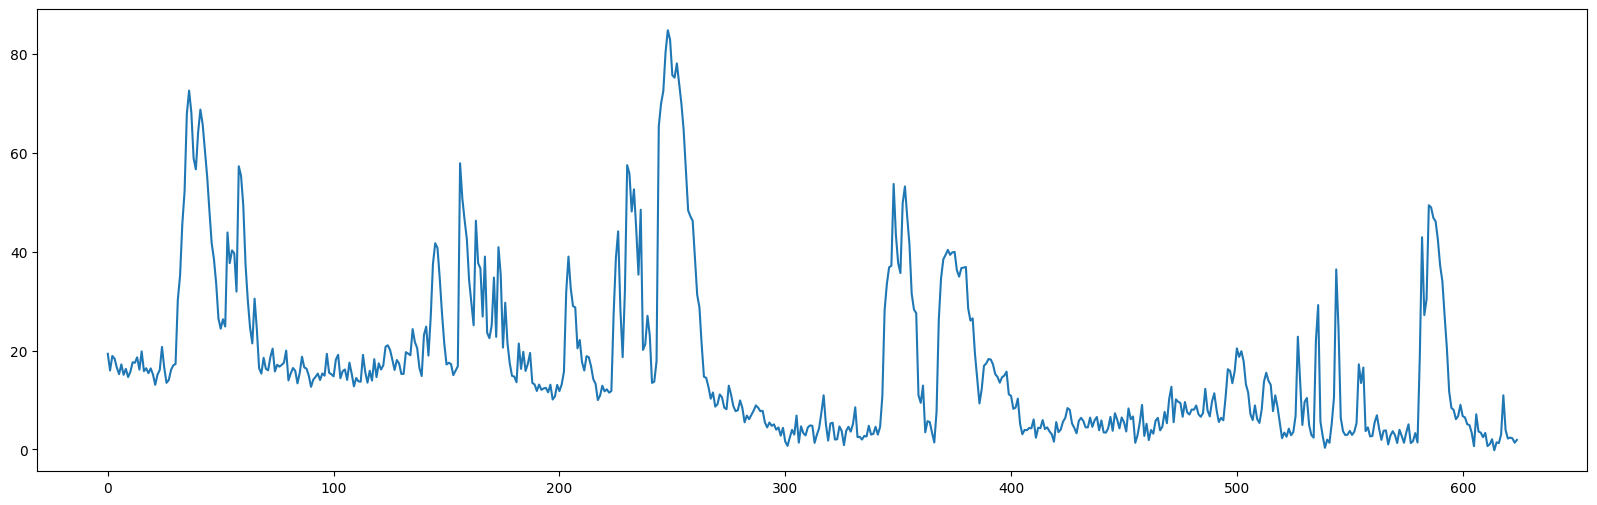

In [5]:
plt.figure(figsize=(20,6))
plt.plot(dbs)
plt.show()

## 延迟统计
< 1.2ms

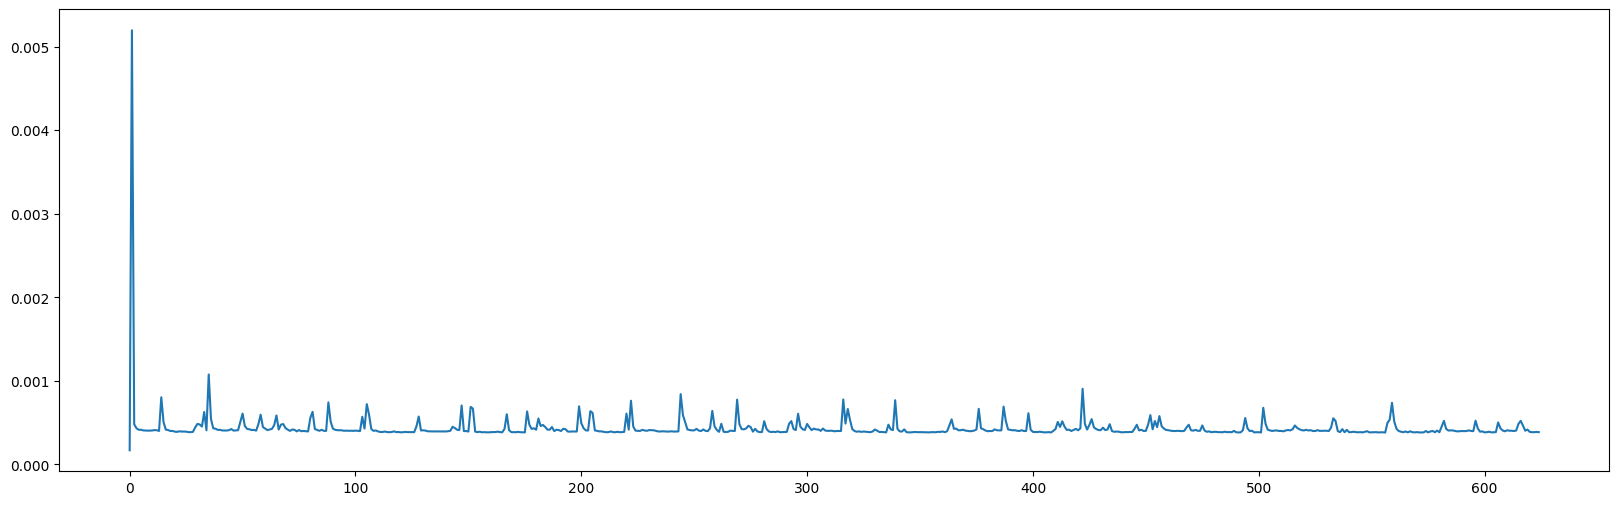

In [6]:
plt.figure(figsize=(20,6))
plt.plot(time_gaps)
plt.show()

In [7]:
sum(time_gaps)

0.27205348014831543